# Music Genre Recognition

In [1]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
import sklearn
import os
import csv
import pickle
import random 
import operator
import math
import numpy as np
import sys
import wave
import pandas as pd
import librosa
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from aubio import source, tempo

### Selecting Features

In [147]:
filename = librosa.util.example_audio_file()
y, sr = librosa.load(filename,offset=25.0,duration=20.0)

chroma_stft = librosa.feature.chroma_stft(y, sr)
spec_cent = librosa.feature.spectral_centroid(y, sr)
spec_bw = librosa.feature.spectral_bandwidth(y, sr)
rolloff = librosa.feature.spectral_rolloff(y, sr)
zcr = librosa.feature.zero_crossing_rate(y)
spec_const = librosa.feature.spectral_contrast(y, sr)
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
mfcc = librosa.feature.mfcc(y, sr)

## MFCC

Any sound generated by humans is determined by the shape of their vocal tract (including tongue, teeth, etc). If this shape can be determined correctly, any sound produced can be accurately represented.

<AxesSubplot:>

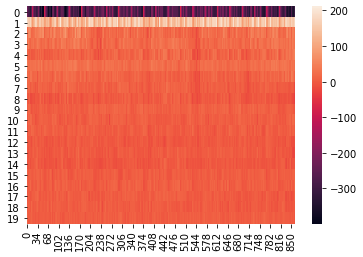

In [15]:
sns.heatmap(mfcc)

## Chroma features

In music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as “pitch class profiles”, are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale.

<AxesSubplot:>

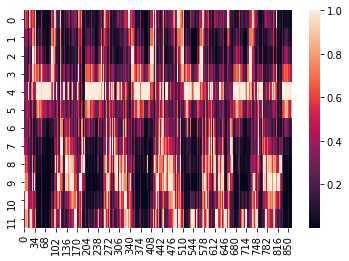

In [16]:
sns.heatmap(chroma_stft)

## Spectral Centroid

The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.

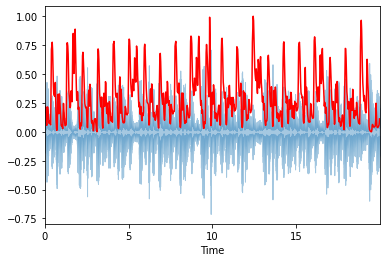

In [153]:
spectral_centroids = spec_cent[0]
spectral_centroids.shape
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

## Spectral Bandwith

Spectral Band Width is an important specification for UV-VIS Spectrophotometer, it affects instrument’s resolution and test error. The spectral bandwidth is defined as the band width of light at one-half the peak maximum. The spectral bandwidth of a spectrophotometer is related to the physical slit-width and optical dispersion of the monochromator system

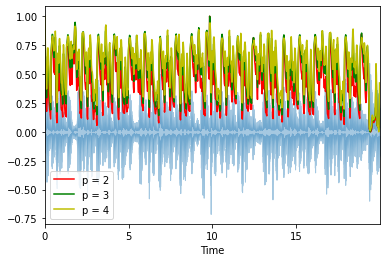

In [30]:
import librosa.display

spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]
spectral_centroids.shape
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)[0]
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

## Zero-crossing Rate

Zero-crossing rate is a measure of number of times in a given time interval/frame that the amplitude of the speech signals passes through a value of zero. This feature has been used heavily in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.

## BPM (Beats Per Minute)

The tempo can be a very helpful feature when distinguishing between two genres (particularly slow blues and hard rock or techno)

### Setting a function to retrieve the tempo (Beats Per Minute) of a given audio file

In [33]:
def get_bpm(filename = 'output.wav'):
    win_s = 1024                 # fft size
    hop_s = win_s // 2           # hop siz

    samplerate = 0
    s = source(filename, samplerate, hop_s)
    samplerate = s.samplerate
    o = tempo("default", win_s, hop_s, samplerate)

    # print(samplerate)

    beats = []
    total_frames = 0
    while True:
        samples, read = s()
        is_beat = o(samples)
        if is_beat:
            this_beat = o.get_last_s()
            beats.append(this_beat)
        total_frames += read
        if read < hop_s: break

    s.close()

    if len(beats) > 1:
        bpms = 60./ np.diff(beats)
        return round(np.median(bpms), 3)

# b = get_bpm('sample2.wav')
# print(b)

# Forming the csv dataset

In [34]:
# Loading Dataset

# header = 'filename chroma_stft bpm spectral_centroid spectral_bandwidth rolloff zero_crossing_rate spectral_contrast pitch'
# for i in range(1, 21):
#     header += f' mfcc{i}'
# header += ' label'
# header = header.split()

# file = open('dataset.csv', 'w', newline='')
# with file:
#     writer = csv.writer(file)
#     writer.writerow(header)
# genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# for g in genres:
#     for filename in os.listdir(f'data/genres/{g}'):
#         songname = f'data/genres/{g}/{filename}'
#         y, sr = librosa.load(songname, mono=True, duration=30)
#         bpm = get_bpm(songname)
#         chroma_stft = librosa.feature.chroma_stft(y, sr)
#         spec_cent = librosa.feature.spectral_centroid(y, sr)
#         spec_bw = librosa.feature.spectral_bandwidth(y, sr)
#         rolloff = librosa.feature.spectral_rolloff(y, sr)
#         zcr = librosa.feature.zero_crossing_rate(y)
#         spec_const = librosa.feature.spectral_contrast(y, sr)
#         pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
#         mfcc = librosa.feature.mfcc(y, sr)
        
#         to_append = f'{filename} {np.mean(chroma_stft)} {bpm} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {np.mean(spec_const)} {np.mean(pitches)}'    
#         for e in mfcc:
#             to_append += f' {np.mean(e)}'
#         to_append += f' {g}'
#         file = open('dataset.csv', 'a', newline='')
#         with file:
#             writer = csv.writer(file)
#             writer.writerow(to_append.split())

In [35]:
data = pd.read_csv('dataset.csv')
data = data.drop(['filename'],axis=1)

In [36]:
data.head()

,chroma_stft,bpm,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,spectral_contrast,pitch,mfcc1,mfcc2,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.349943,64.076,1784.420446,2002.650192,3806.485316,0.083066,20.530733,18.323206,-113.596748,121.557297,...,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
1,0.340983,51.160,1529.835316,2038.617579,3548.820207,0.056044,20.676334,7.699259,-207.556793,124.006721,...,5.376803,-2.239120,4.216963,-6.012273,0.936109,-0.716537,0.293876,-0.287431,0.531573,blues
2,0.363603,81.211,1552.481958,1747.165985,3040.514948,0.076301,22.197265,21.907356,-90.754387,140.459900,...,5.789265,-8.905224,-1.083720,-9.218358,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
3,0.404779,95.139,1070.119953,1596.333948,2185.028454,0.033309,21.428764,4.727277,-199.431152,150.099213,...,6.087676,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,blues
4,0.308590,68.817,1835.494603,1748.362448,3580.945013,0.101500,21.467739,27.249077,-160.266037,126.198799,...,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409332,-11.703781,blues


In [37]:
genres = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genres)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data.iloc[:, :-1]),columns = data.iloc[:, :-1].columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. MLP Classifier

In [140]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=0.1, hidden_layer_sizes=(50,), random_state=1, max_iter=2000)
clf.fit(X_train,y_train)

c:\users\avagy\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.1, hidden_layer_sizes=(50,), max_iter=2000,
              random_state=1, solver='lbfgs')

In [141]:
from sklearn.metrics import hinge_loss

y_pred = clf.predict(X_test)
MLP_accuracy = accuracy_score(y_test, y_pred)
print(MLP_accuracy)

0.705


## 2. KNN

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
algorithms = ['auto', 'kd_tree']

param_grid = dict(n_neighbors = k_range, weights = weight_options, algorithm = algorithms)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = ('f1_weighted','accuracy'), refit='accuracy', n_jobs = -1)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             refit='accuracy', scoring=('f1_weighted', 'accuracy'))

In [70]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.6162499999999999
{'algorithm': 'kd_tree', 'n_neighbors': 6, 'weights': 'distance'}
KNeighborsClassifier(algorithm='kd_tree', n_neighbors=6, weights='distance')


In [73]:
y_pred = grid.predict(X_test)
KNN_accuracy = accuracy_score(y_test, y_pred)
print(KNN_accuracy)

0.63


## 3. SVC

In [74]:
from sklearn import svm

clf = svm.SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']} 
  
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 2, n_jobs = 2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=2)

In [75]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.6925000000000001
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)


In [76]:
y_pred = grid.predict(X_test)
SVC_accuracy = accuracy_score(y_test, y_pred)
print(SVC_accuracy)

0.645


## 4. Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(n_estimators=25, random_state=0)
param_grid = {'max_depth': range(2, 10), 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_split' : [2, 5, 10], 'bootstrap' : [True, False]}
grid_search = GridSearchCV(tree, param_grid, cv=3, n_jobs=2, verbose=1)
grid_search.fit(X, y)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=25, random_state=0),
             n_jobs=2,
             param_grid={'bootstrap': [True, False], 'max_depth': range(2, 10),
                         'min_samples_split': [2, 5, 10]},
             verbose=1)

In [100]:
print (grid.best_score_)
print (grid.best_params_)

0.6712500095367432
{'activation': 'relu', 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}


In [104]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
RF_accuracy = accuracy_score(y_test, y_pred)
print(RF_accuracy)

0.64


## Neural Network

### Hyperparameter tuning

In [79]:
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(optimizer='adam', activation='relu'):    
    model = Sequential()
    model.add(layers.Dense(256, kernel_initializer='random_uniform', activation=activation, input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(128, kernel_initializer='uniform', activation=activation))
    model.add(layers.Dense(64, activation=activation))
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=2)
activation = ('relu', 'sigmoid')
optimizer = ['RMSprop', 'Adam']
batch_size = [64, 128, 256]
epochs = [100]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs = 4, verbose=2)
grid_result = grid.fit(X_train, y_train, validation_data = (X_test,y_test))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Epoch 1/100
7/7 - 2s - loss: 2.2750 - accuracy: 0.2350 - val_loss: 2.2394 - val_accuracy: 0.2250
Epoch 2/100
7/7 - 0s - loss: 2.1526 - accuracy: 0.3638 - val_loss: 2.1306 - val_accuracy: 0.2950
Epoch 3/100
7/7 - 0s - loss: 1.9731 - accuracy: 0.3887 - val_loss: 1.9893 - val_accuracy: 0.3050
Epoch 4/100
7/7 - 0s - loss: 1.7723 - accuracy: 0.4000 - val_loss: 1.8417 - val_accuracy: 0.3250
Epoch 5/100
7/7 - 0s - loss: 1.5992 - accuracy: 0.4437 - val_loss: 1.7435 - val_accuracy: 0.3250
Epoch 6/100
7/7 - 0s - loss: 1.4462 - accuracy: 0.4850 - val_loss: 1.6252 - val_accuracy: 0.3600
Epoch 7/100
7/7 - 0s - loss: 1.3190 - accuracy: 0.5250 - val_loss: 1.5278 - val_accuracy: 0.4450
Epoch 8/100
7/7 - 0s - loss: 1.2202 - accuracy: 0.5825 - val_loss: 1.4840 - val_accuracy: 0.4550
Epoch 9/100
7/7 - 0s - loss: 1.1489 - accuracy: 0.6037 - val_loss: 1.4879 - val_accuracy: 0.4700
Epoch 10/100
7/7 - 0s - loss: 1.0933 - accuracy: 0.6112 - val_lo

Epoch 85/100
7/7 - 0s - loss: 0.0512 - accuracy: 0.9887 - val_loss: 2.0223 - val_accuracy: 0.6000
Epoch 86/100
7/7 - 0s - loss: 0.0475 - accuracy: 0.9912 - val_loss: 2.0227 - val_accuracy: 0.6100
Epoch 87/100
7/7 - 0s - loss: 0.0420 - accuracy: 0.9937 - val_loss: 2.0651 - val_accuracy: 0.5800
Epoch 88/100
7/7 - 0s - loss: 0.0404 - accuracy: 0.9962 - val_loss: 2.0468 - val_accuracy: 0.6000
Epoch 89/100
7/7 - 0s - loss: 0.0385 - accuracy: 0.9950 - val_loss: 2.0388 - val_accuracy: 0.6100
Epoch 90/100
7/7 - 0s - loss: 0.0350 - accuracy: 0.9987 - val_loss: 2.1107 - val_accuracy: 0.5950
Epoch 91/100
7/7 - 0s - loss: 0.0389 - accuracy: 0.9962 - val_loss: 2.0684 - val_accuracy: 0.5950
Epoch 92/100
7/7 - 0s - loss: 0.0361 - accuracy: 0.9975 - val_loss: 2.1646 - val_accuracy: 0.5950
Epoch 93/100
7/7 - 0s - loss: 0.0413 - accuracy: 0.9962 - val_loss: 2.1178 - val_accuracy: 0.6100
Epoch 94/100
7/7 - 0s - loss: 0.0329 - accuracy: 0.9987 - val_loss: 2.1395 - val_accuracy: 0.6050
Epoch 95/100
7/7 - 0

In [80]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.671250 using {'activation': 'relu', 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}
0.643750 (0.038426) with: {'activation': 'relu', 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}
0.663750 (0.034664) with: {'activation': 'relu', 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}
0.656250 (0.038426) with: {'activation': 'relu', 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}
0.671250 (0.057022) with: {'activation': 'relu', 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}
0.635000 (0.051478) with: {'activation': 'relu', 'batch_size': 256, 'epochs': 100, 'optimizer': 'RMSprop'}
0.645000 (0.047828) with: {'activation': 'relu', 'batch_size': 256, 'epochs': 100, 'optimizer': 'Adam'}
0.493750 (0.054844) with: {'activation': 'sigmoid', 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}
0.538750 (0.047253) with: {'activation': 'sigmoid', 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}
0.480000 (0.048798) with: {'activation': 'sigmoid', 'ba

In [84]:
print (grid.best_score_)
print (grid.best_params_)

0.6712500095367432
{'activation': 'relu', 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}


### Estimation

In [144]:
model = Sequential()
model.add(layers.Dense(256, kernel_initializer='random_uniform', activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100, batch_size=128)

Epoch 1/100
7/7 [==============================] - 1s 51ms/step - loss: 2.2857 - accuracy: 0.2258 - val_loss: 2.2132 - val_accuracy: 0.2850
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 2.1668 - accuracy: 0.3624 - val_loss: 2.0654 - val_accuracy: 0.3000
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 1.9394 - accuracy: 0.3864 - val_loss: 1.9288 - val_accuracy: 0.3100
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 1.7409 - accuracy: 0.3969 - val_loss: 1.8163 - val_accuracy: 0.3200
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 1.5470 - accuracy: 0.4377 - val_loss: 1.6656 - val_accuracy: 0.3700
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 1.3952 - accuracy: 0.4704 - val_loss: 1.5721 - val_accuracy: 0.3950
Epoch 7/100
7/7 [==============================] - 0s 5ms/step - loss: 1.2721 - accuracy: 0.5428 - val_loss: 1.5191 - val_accuracy: 0.4450
Epoch 8/100
7/7 [=========

In [145]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
NN_accuracy = accuracy_score(y_test, y_pred)
print(NN_accuracy)

0.65


# Based on Accuracy Score, we select MLP Classifier